In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [2]:
data = pd.read_csv("./1-1-a.csv")
data["h"] = data["v2"] / data["v1"]
data["phase"] = (-data["frequency"] * data["t"] * 1e-9 * 360 + 180) % 360 - 180
print(data)


    frequency   v1     v2       t         h     phase
0        10.0  161   0.00     NaN  0.000000       NaN
1       100.0  163   0.00     NaN  0.000000       NaN
2      1000.0  162   0.00     NaN  0.000000       NaN
3     10000.0  162   0.00     NaN  0.000000       NaN
4     20000.0  162   0.00     NaN  0.000000       NaN
5     50000.0  168   0.60  6000.0  0.003571 -108.0000
6    100000.0  164   1.45  7600.0  0.008841   86.4000
7    200000.0  164   3.00 -1300.0  0.018293   93.6000
8    500000.0  162   9.00  -480.0  0.055556   86.4000
9    600000.0  162  11.70  -370.0  0.072222   79.9200
10   700000.0  160  16.00  -320.0  0.100000   80.6400
11   800000.0  160  23.00  -270.0  0.143750   77.7600
12   900000.0  156  34.00  -218.0  0.217949   70.6320
13   950000.0  154  45.50  -180.0  0.295455   61.5600
14   960000.0  152  48.20  -176.0  0.317105   60.8256
15   970000.0  151  51.10  -164.0  0.338411   57.2688
16   980000.0  151  54.40  -160.0  0.360265   56.4480
17   990000.0  149  57.70  -

In [3]:
def admittance_complex(w, R, L, C):
    return 1/(R + 1j * (w * L - 1 / (w * C)))

[2.39518280e+01 4.19530204e-05]
theory:  0.8945324068246716
fit:  0.17771838673710355


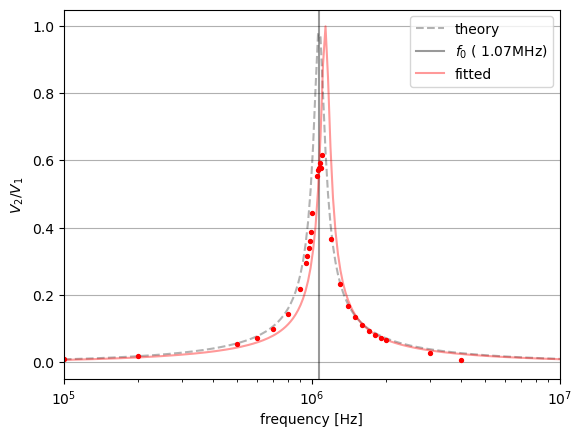

In [4]:
# C=470pF固定として、L, Rを最適化

admittance_abs = lambda f, R, L: abs(R * admittance_complex(2 * np.pi * f, R, L, 4.7e-10))
popt, pcov = curve_fit(admittance_abs, data["frequency"], data["h"], bounds=([20, 3e-5], [60, 6e-5]))


print(popt)
admittance_abs_theory = lambda f: admittance_abs(f, 30, 4.7e-5)
admittance_abs_opt = lambda f: admittance_abs(f, *popt)

print("theory: ", sum([(row["h"] - admittance_abs_theory(row["frequency"]))**2 for index, row in data.iterrows()]))
print("fit: ", sum([(row["h"] - admittance_abs_opt(row["frequency"]))**2 for index, row in data.iterrows()]))

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(xlim=(1e5, 1e7), xscale="log", legend=True, xlabel="frequency [Hz]", grid="y", ylabel="$V_2/V_1$")
axessetting.plot_func(ax, admittance_abs_theory, label="theory", alpha=0.3, ls="dashed", c="black")
ax.axvline(1 / (2 * np.pi * 4.7 * 10**-7.5), alpha=0.4, c="black", label=f"$f_{{0}}$ ({10**1.5/2/4.7/np.pi: .2f}MHz)")
axessetting.plot_func(ax, admittance_abs_opt, label="fitted", alpha=0.4, c="r")
ax.scatter(data["frequency"], data["h"], s=8, c="r", zorder=2)
axessetting.apply_axes(ax)

In [5]:
# Q value
y_cutoff = np.max(data["h"]) / np.sqrt(2)
f_peak = data.loc[data["h"].idxmax()]["frequency"]

tuplify = lambda x: (x["frequency"], x["h"])
# 17 & 18
f_min = linear_sim(tuplify(data.iloc[17]), tuplify(data.iloc[18]), y_cutoff)
#24 & 25
f_max = linear_sim(tuplify(data.iloc[24]), tuplify(data.iloc[25]), y_cutoff)

print(f"Calculated Q = {f_peak / (f_max - f_min): .2f}")
print(f"{f_peak: .2e}, {f_min: .2e}, {f_max: .2e}")

Calculated Q =  6.33
 1.10e+06,  9.99e+05,  1.17e+06


[4.32109487e+01 4.65202382e-05]


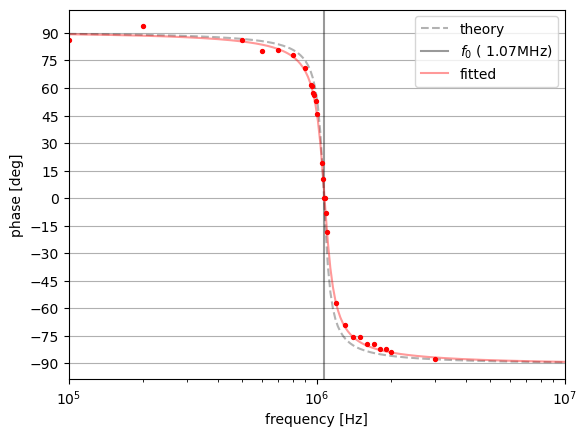

In [6]:
# C=470pF固定として、L, Rを最適化
data_arg = data[["frequency", "phase"]].dropna().drop([5, 35])
admittance_arg = lambda f, R, L: np.angle(R * admittance_complex(2 * np.pi * f, R, L, 4.7e-10), deg=True)
popt, pcov = curve_fit(admittance_arg, data_arg["frequency"], data_arg["phase"], bounds=([20, 3e-5], [100, 7e-5]))
print(popt)
admittance_arg_theory = lambda f: admittance_arg(f, 30, 4.7e-5)
admittance_arg_opt = lambda f: admittance_arg(f, *popt)

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(xlim=(1e5, 1e7), xscale="log", legend=True, xlabel="frequency [Hz]", grid="y", ylabel="phase [deg]")
axessetting.plot_func(ax, admittance_arg_theory, label="theory", alpha=0.3, ls="dashed", c="black")
ax.axvline(1 / (2 * np.pi * 4.7 * 10**-7.5), alpha=0.4, c="black", label=f"$f_{{0}}$ ({10**1.5/2/4.7/np.pi: .2f}MHz)")
axessetting.plot_func(ax, admittance_arg_opt, label="fitted", alpha=0.4, c="red")

ax.scatter(data_arg["frequency"], data_arg["phase"], s=8, c="red", zorder=2)
axessetting.apply_axes(ax)
ax.set_yticks(np.linspace(-90, 90, 13))

In [7]:
data_arg

,frequency,phase
6,100000.0,86.4000
7,200000.0,93.6000
8,500000.0,86.4000
9,600000.0,79.9200
10,700000.0,80.6400
11,800000.0,77.7600
12,900000.0,70.6320
13,950000.0,61.5600
14,960000.0,60.8256
15,970000.0,57.2688


In [8]:
# Q value
f_peak = data_arg.loc[21]["frequency"]

tuplify = lambda x: (x["frequency"], x["phase"])
# 17 & 18
f_min = linear_sim(tuplify(data.iloc[18]), tuplify(data.iloc[19]), 45)
#24 & 25
f_max = linear_sim(tuplify(data.iloc[24]), tuplify(data.iloc[25]), -45)

print(f"Calculated Q = {f_peak / (f_max - f_min): .2f}")
print(f"{f_peak: .2e}, {f_min: .2e}, {f_max: .2e}")

Calculated Q =  6.41
 1.07e+06,  1.00e+06,  1.17e+06


In [9]:
def step_response(t, V, C, L, R): #i
    a = R / (2 * L)
    b_inside = (R / (2*L)) ** 2 - 1/(L * C)
    if b_inside > 0:
        b = np.sqrt(b_inside)
        return V / (b * L) * np.exp(-a * t) * np.sinh(b * t) * R
    elif b_inside == 0:
        return V * t / L * np.exp(-a * t) * R
    else:
        beta = np.sqrt(-b_inside)
        return V / (beta * L) * np.exp(-a * t) * np.sin(beta * t) * R



In [16]:
def plot_steppe(fname, R_used, delay=0.6e-7, ax=None):
    #ここに数値を入力
    df_read = pd.read_csv(fname, skiprows=[1])
    Q = np.sqrt(4.7e-5/4.7e-10) / R_used
    df_read["X"] += delay
    v_read = np.mean(df_read[df_read["CH1"] > 0]["CH1"])
    step_response_theory_read = lambda t: step_response(t, v_read, 4.7e-10, 4.7e-5, R_used)

    #popt, pcov = curve_fit(step_response, df_05["Second"], df_05["Volt.1"], bounds=([0.05, 4e-10, 4e-5, 500], [5, 8e-10, 8e-5, 5000]))
    #print(popt)

    axessetting = AxesSetting(title=f"R={R_used}Ω, Q={Q: .2f}", legend=False, xlim=(0, 3e-6), grid={"which": "major", "axis":"y"})

    ax.plot(df_read["X"], df_read["CH1"], label="V1", c="#00ee00")
    ax.plot(df_read["X"], df_read["CH2"], label="V2", c="red")
    # axessetting.plot_func(ax, lambda t: step_response(t, *popt), label="fitted", alpha=0.6, c="lime")
    axessetting.plot_func(ax, step_response_theory_read, label="theory", alpha=0.4, samplesize=1000, c="black", ls="dashed")
    # ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
    axessetting.apply_axes(ax)

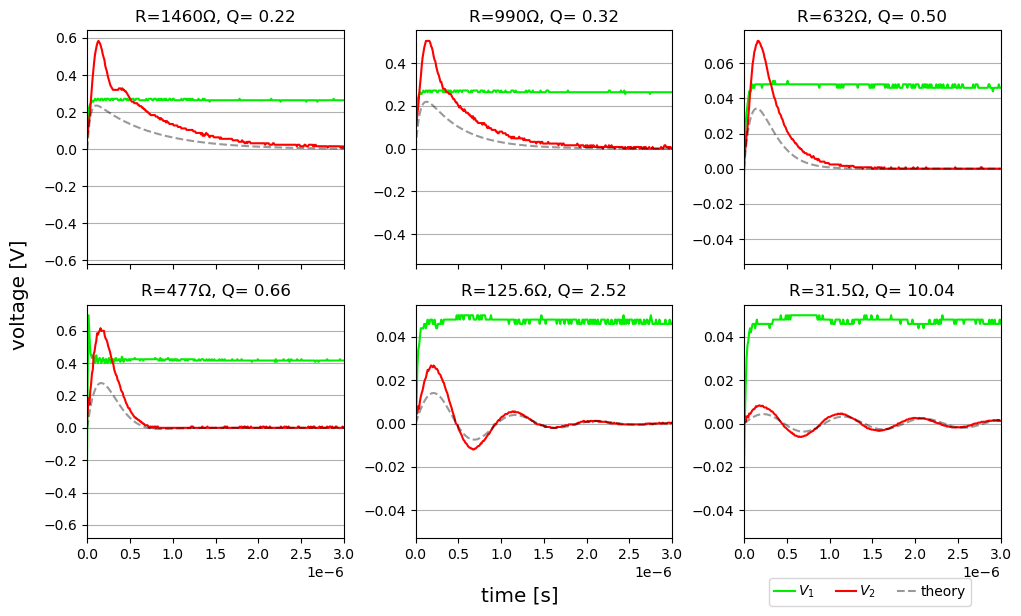

In [17]:
fig, axes = plt.subplots(2, 3, sharex="all", figsize=(10, 6))
ls_rlcs = [
    ("reexpr.csv", 1460, 0.1e-7),
    ("reexp.csv", 990, 0),
    ("q0_5.csv", 632, 6e-8),
    ("rer.csv", 477, 0.04e-7),
    ("q2_5.csv", 125.6, 6e-8),
    ("q0wFile0.csv", 31.5, 7e-8)
]
for i, data in enumerate(ls_rlcs):
    plot_steppe(*data, axes[i//3, i%3])    
plt.figlegend(axes[0,0].lines, ["$V_1$", "$V_2$", "theory"], loc="lower center", ncol=3, bbox_to_anchor=(0.85, -0.03), columnspacing=1.5, handlelength=1.5, handletextpad=0.2)
fig.text(0.5, -0.01, "time [s]", ha="center", fontsize="x-large")
fig.text(-0.01, 0.5, "voltage [V]", va="center", rotation="vertical", fontsize="x-large")
fig.tight_layout()